In [21]:
#import packages
import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import logging
import numpy as np

#custom classes
from classes import classes as cl
from functions import functions as fc

plt.rcParams.update({'font.size': 22})

Initiation

In [22]:
#create empty dict
initiation_objects = {'dict_depots': '', 'dict_sites': '', 'dict_plants': '', 'dict_jobs': '', 'dict_tours': '', 'list_days': ''}
init_path = 'output/inital_solution'

objects = fc.initiate(initiation_objects,init_path,'final')

#load objects
list_days = objects['list_days']
dict_depots = objects['dict_depots']
dict_sites = objects['dict_sites']
dict_plants = objects['dict_plants']
dict_jobs = objects['dict_jobs']
dict_tours = objects['dict_tours']

#also create lists for convenience
list_depots = [dict_depots[element] for element in dict_depots]
list_sites = [dict_sites[element] for element in dict_sites]
list_plants = [dict_plants[element] for element in dict_plants]
list_jobs = [dict_jobs[element] for element in dict_jobs]
list_tours  = [dict_tours[element] for element in dict_tours]

Starting initiation at 20:58:20


In the first stage only one depot ist handled, so moves so its all about dropoff and pickup dates

In [23]:
#ov tours
for depot in dict_depots:
    total_tasks = 0
    total_distance = 0
    for day in list_days:
        total_tasks += dict_tours[depot][day].total_tasks
        total_distance += dict_tours[depot][day].distance
    print("Depot: {}, tasks: {} - distance: {}".format(depot,total_tasks,total_distance))



Depot: Neuherberg, tasks: 25454 - distance: 4547134.5148212565
Depot: Lauterhofen, tasks: 14329 - distance: 2151298.5445965845
Depot: Altbach, tasks: 5534 - distance: 648999.0083624776
Depot: Deisslingen, tasks: 0 - distance: 0
Depot: Bollschweil, tasks: 1586 - distance: 167723.71699792094
Depot: Lampertheim, tasks: 5872 - distance: 1059256.2914196497
Depot: Neuss, tasks: 19062 - distance: 2374315.453137417
Depot: Embsen, tasks: 9216 - distance: 1121736.368534145
Depot: Rottleberode, tasks: 25304 - distance: 6393335.900862845
Depot: Fenne, tasks: 0 - distance: 0
Depot: Castrop, tasks: 0 - distance: 0
Depot: Perl, tasks: 0 - distance: 0
Depot: Gnetsch, tasks: 0 - distance: 0
Depot: Vogelsdorf, tasks: 0 - distance: 0
Depot: Sukow, tasks: 0 - distance: 0


In [26]:
#only work with one depot
temp_depot = dict_depots['Neuss']
list_depots = [temp_depot]
dict_depots = {'Neuss': temp_depot}



solution_initial = cl.Solution(temp_depot,dict_tours,list_days)

#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#solution_initial.plot_tasks(50)
#solution_initial.plot_task_proportion()


NameError: name 'yaxis' is not defined

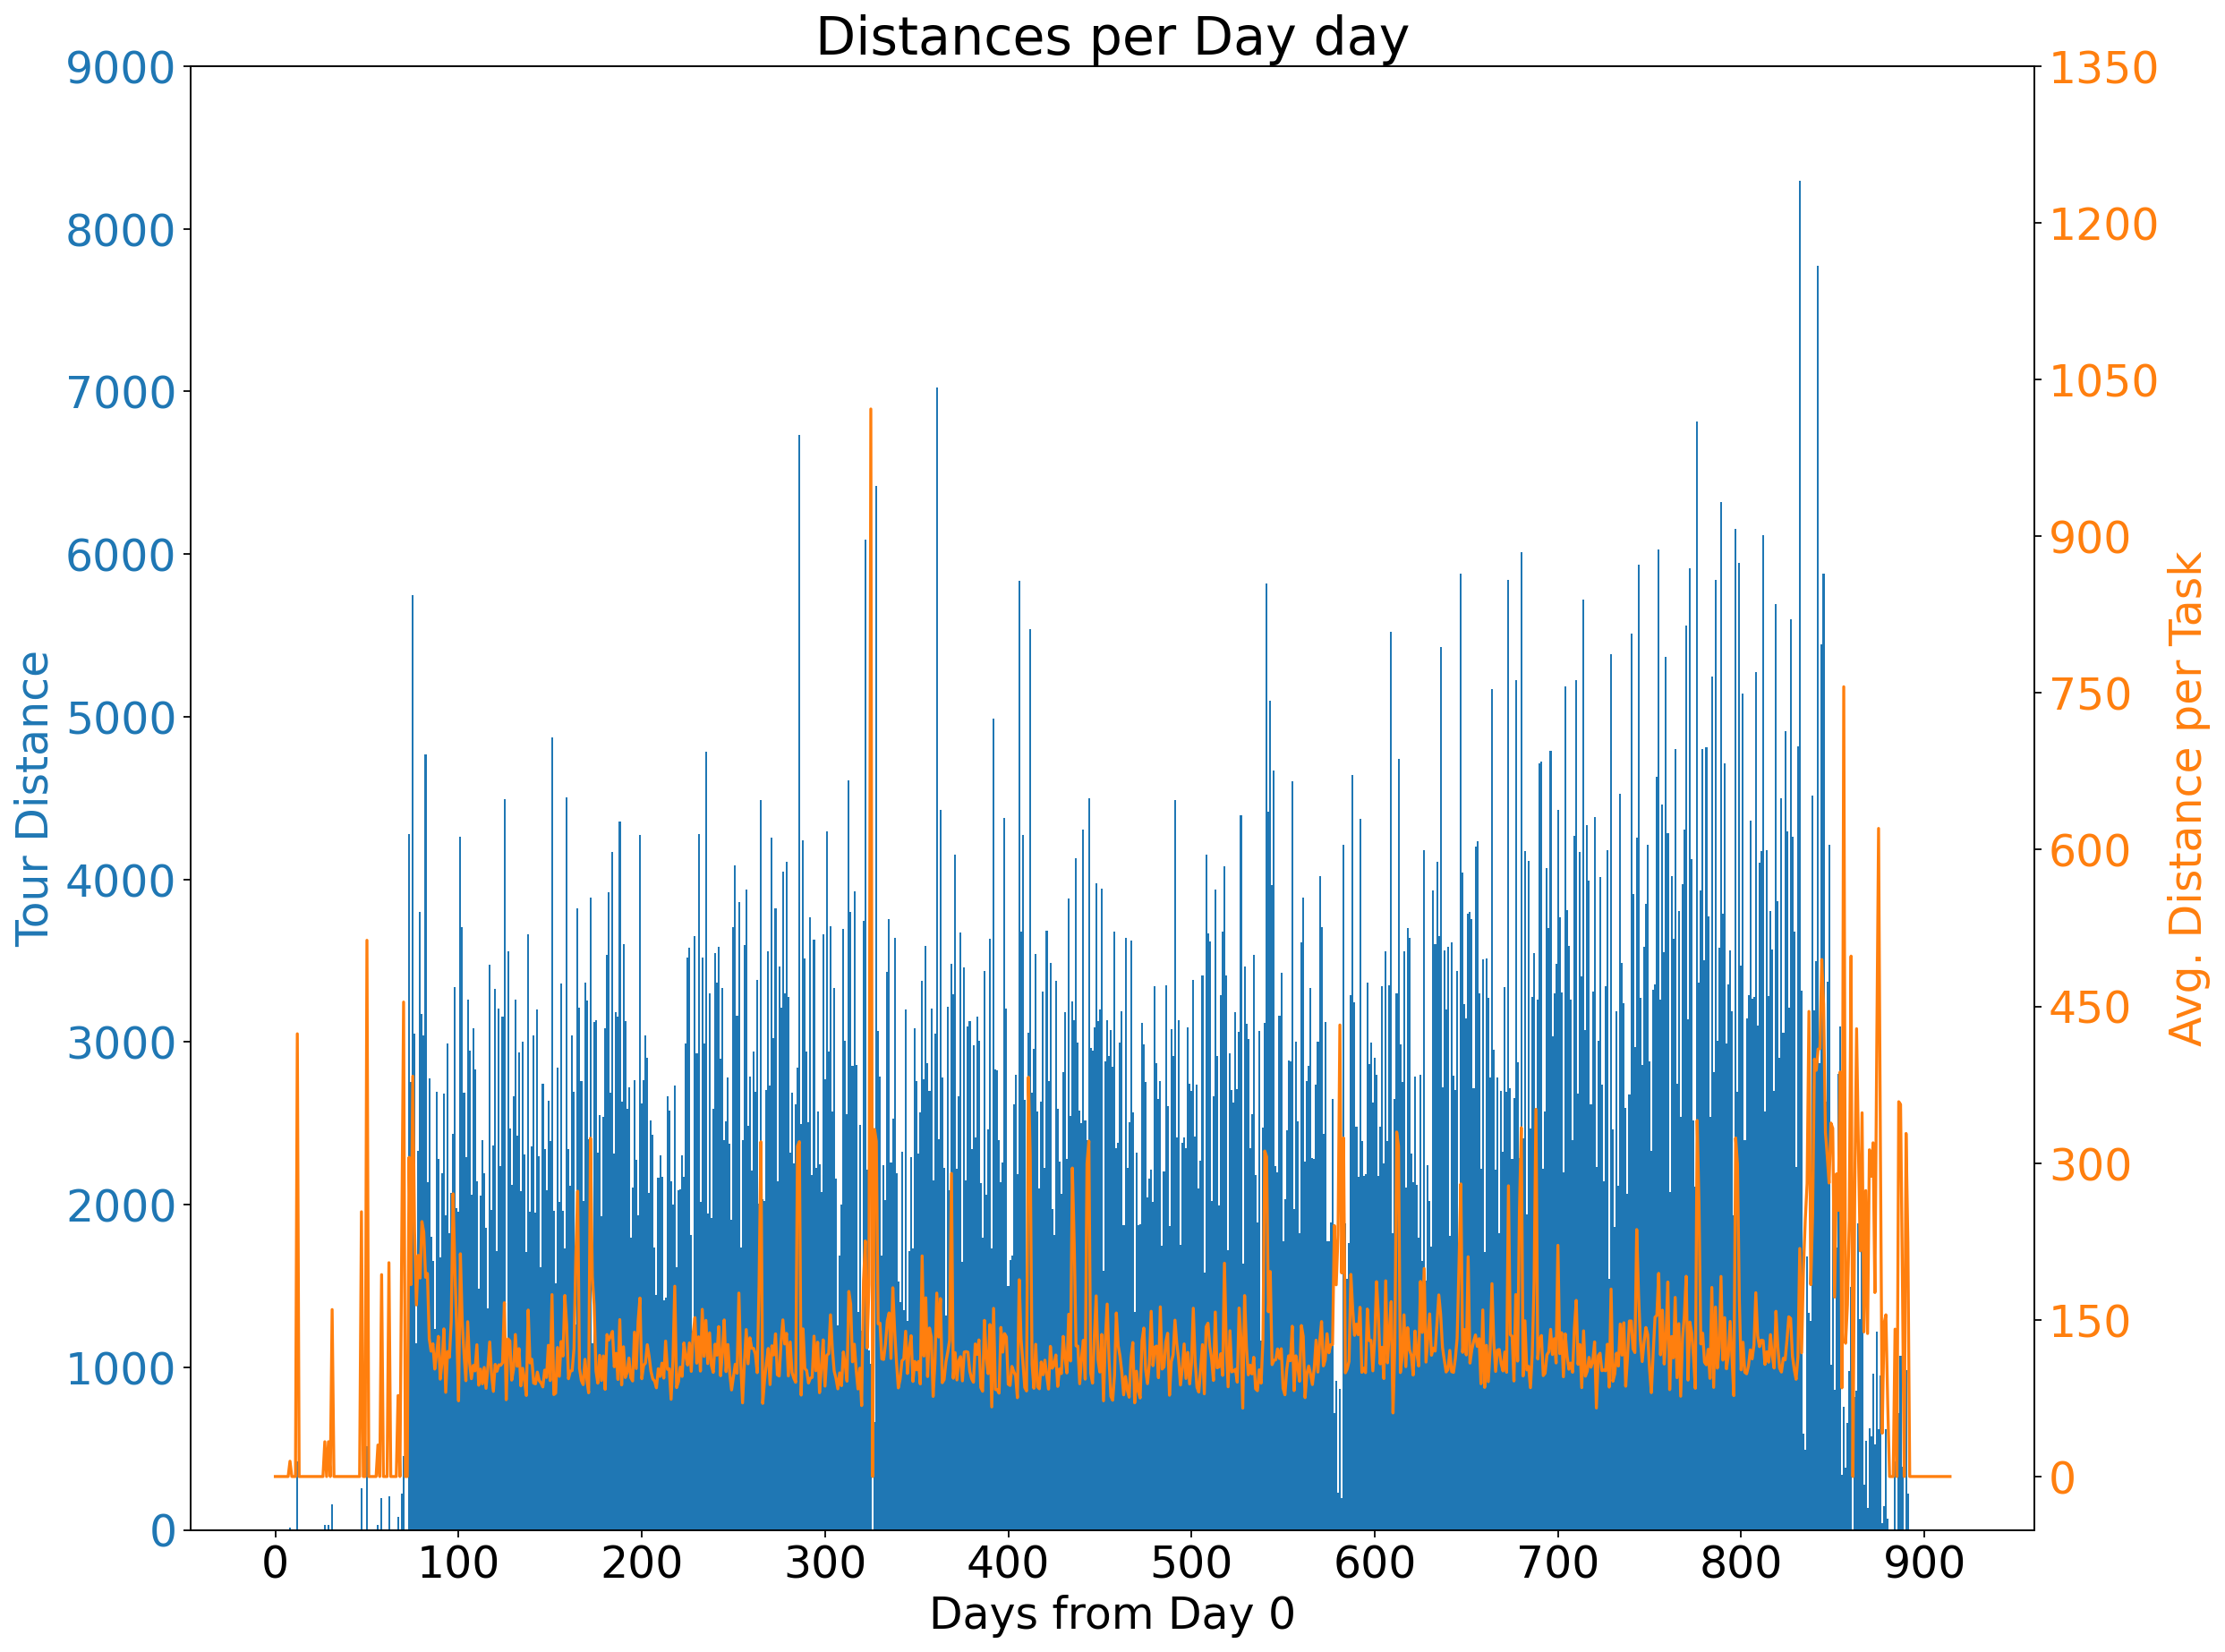

In [25]:
solution_initial.plot_distances(10000,1500)

In [ ]:
"""list tasks

i = 0
for day in list_days:
    dos = solution_initial.dict_dropoffs_daily[day]
    pis = solution_initial.dict_pickups_daily[day]
    tot = dos + pis

    if dos >0:
        print("Day {}, Total: {}, Dropoffs: {}, Pickups: {}, real day = {}".format(i,tot,dos,pis,day))

    i+= 1

"""
"""

i = 0
for day in list_days:
    dos = solution_initial.dict_dropoffs_daily[day]
    pis = solution_initial.dict_pickups_daily[day]
    tot = solution_initial.dict_distance_daily[day]
    if True:
        print("Day {}, Total: {}, Dropoffs: {}, Pickups: {}, real day = {}".format(i,tot,dos,pis,day))

    i+= 1"""

